In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras, config
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [7]:
def TrainData():
    fake_img = r"archive\train\FAKE"
    real_img = r"archive\train\REAL"
    image = []
    label = []

    random_fake = np.random.choice(os.listdir(fake_img), 40000, replace=False)
    random_real = np.random.choice(os.listdir(real_img), 40000, replace=False)

    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(random_fake, desc='Fake Training Data'):
        data = cv2.imread(os.path.join(fake_img, path))
        image.append(data)
        label.append(0)

    for path in tqdm(random_real, desc='Real Training Data'):
        data = cv2.imread(os.path.join(real_img, path))
        image.append(data)
        label.append(1)

    print()
    # image augmantation
    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)
    gen_image = []
    gen_label = []
    gen = ImageDataGenerator(
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True,
    )
    gen.fit(image)

    for i, j in gen.flow(image, label, batch_size=200):
        gen_image.append(i)
        gen_label.append(j)
        if len(gen_image)%50==0:
            print(f'{len(gen_image)*200}/80000 augmented data generated.')
        if len(gen_image)==400:
            print('Data augmentation done')
            break
    image = np.concatenate(gen_image)
    label = np.array(gen_label).flatten()

    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)
    image = image/255.0

    state = np.random.get_state()
    np.random.shuffle(image)
    np.random.set_state(state)
    np.random.shuffle(label)
    print('\nShuffle training data done.\n')
    print(f'Total training data : {len(image)}')
    
    return image, label

In [8]:
def TestData():
    fake_path = r"archive\test\FAKE"
    real_path = r"archive\test\REAL"
    image = []
    label = []
    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(os.listdir(fake_path), desc='Fake Testing Data'):
        data = cv2.imread(os.path.join(fake_path, path))
        image.append(data)
        label.append(0)
    
    for path in tqdm(os.listdir(real_path), desc='Real Testing Data'):
        data = cv2.imread(os.path.join(real_path, path))
        image.append(data)
        label.append(1)

    image=np.array(image).reshape(-1, 32, 32, 3)
    image=image/255
    label=np.array(label)

    return image, label

In [9]:
def CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [10]:
train_x, train_y = TrainData()

Real Training Data: 100%|██████████| 40000/40000 [02:22<00:00, 280.34it/s]



10000/80000 augmented data generated.
20000/80000 augmented data generated.
30000/80000 augmented data generated.
40000/80000 augmented data generated.
50000/80000 augmented data generated.
60000/80000 augmented data generated.
70000/80000 augmented data generated.
80000/80000 augmented data generated.
Data augmentation done

Shuffle training data done.

Total training data : 80000


In [11]:
test_x, test_y = TestData()

Real Testing Data: 100%|██████████| 10000/10000 [00:59<00:00, 168.57it/s]


In [12]:
"""
Tensorflow supports running computations on GPU 

WARNING : You need to have CUDA, cuDNN, and tensorflow with version lower than 2.11.0, 
          if not, DON'T execute this cell.
"""
physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print('Running on GPU available now')

Running on GPU available now


In [13]:
model = CNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [14]:
history = model.fit(train_x, train_y, epochs=20, batch_size=200, validation_data=(test_x, test_y))

Epoch 1/20
400/400 [==============================] - 9s 9ms/step - loss: 0.4777 - accuracy: 0.7640 - val_loss: 0.5686 - val_accuracy: 0.7560
Epoch 2/20
400/400 [==============================] - 3s 8ms/step - loss: 0.3672 - accuracy: 0.8377 - val_loss: 0.5590 - val_accuracy: 0.7786
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 0.3327 - accuracy: 0.8570 - val_loss: 0.4953 - val_accuracy: 0.7951
Epoch 4/20
400/400 [==============================] - 3s 8ms/step - loss: 0.2992 - accuracy: 0.8728 - val_loss: 0.4780 - val_accuracy: 0.8076
Epoch 5/20
400/400 [==============================] - 3s 8ms/step - loss: 0.2768 - accuracy: 0.8846 - val_loss: 0.4360 - val_accuracy: 0.8285
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 0.2648 - accuracy: 0.8897 - val_loss: 0.4198 - val_accuracy: 0.8327
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 0.2400 - accuracy: 0.9016 - val_loss: 0.3365 - val_accuracy: 0.8651
Epoch 

In [15]:
predicted = model.predict(test_x)

625/625 [==============================] - 1s 1ms/step


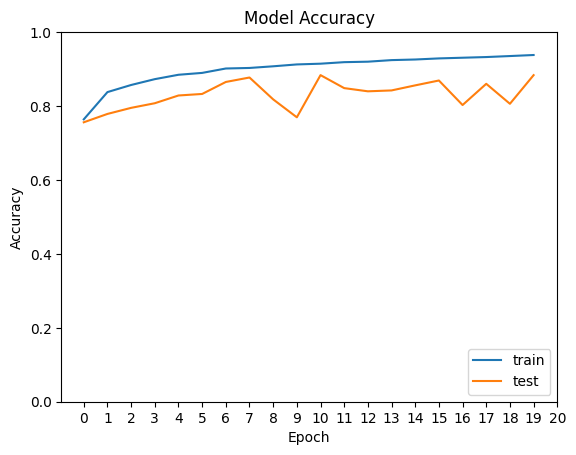

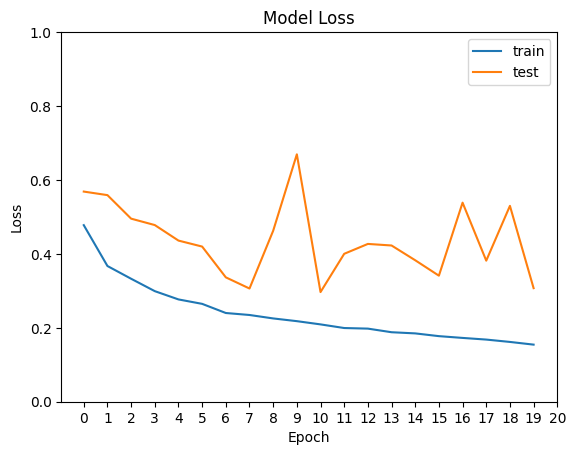

In [16]:
# Plot the loss and accuracy of training set.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(range(0, 21, 1))
plt.ylim(0, 1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0, 21, 1))
plt.ylim(0, 1)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [17]:
predicted = [int(round(i[0])) for i in predicted]
print('\nClassification Report:\n----------------------\n', classification_report(test_y, predicted))


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.82      0.98      0.89     10000
           1       0.97      0.79      0.87     10000

    accuracy                           0.88     20000
   macro avg       0.90      0.88      0.88     20000
weighted avg       0.90      0.88      0.88     20000



In [18]:
# Save Model
model.save('Models/CNN.h5')